In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import re
import matplotlib.pyplot as plt

In [2]:
import mapping

## Getting data from NHL, NBA, MLB, NFL and the corresponding populations from the teams region

In [3]:
nhl_df=pd.read_csv("datasets/nhl.csv")
nba_df=pd.read_csv("datasets/nba.csv")
mlb_df=pd.read_csv("datasets/mlb.csv")
nfl_df=pd.read_csv("datasets/nfl.csv")

In [4]:
cities=pd.read_html("datasets/wikipedia_data.html")[1]
cities=cities.iloc[:-1,[0,3,5,6,7,8]]

# Data Cleaning (Whitespaces, '*', ...) and Mapping the sports team to the region

In [5]:
#Cleaning the cities dataset
cities = cities.rename(columns={cities.columns[1]:'Population'})
cities = cities[['Metropolitan area','Population']].set_index('Metropolitan area')
cities.index = cities.index.str.strip()
cities['Population'] = cities['Population'].astype('float64')

In [6]:
#Looking at a specific year for the sports datasets
nhl_df = nhl_df[nhl_df['year']==2018]
nba_df = nba_df[nba_df['year']==2018]
mlb_df = mlb_df[mlb_df['year']==2018]
nfl_df = nfl_df[nfl_df['year']==2018]

In [7]:
#Cleaning NHL Dataset
nhl_df['team'] = nhl_df['team'].str.replace('*','')
nhl_df = nhl_df[['team','W','L']].set_index('team')
nhl_df = nhl_df.drop(['Atlantic Division','Metropolitan Division',
                      'Central Division','Pacific Division'])

In [8]:
#Cleaning NBA Dataset
nba_df['team'] = nba_df['team'].str.replace('*','')
nba_df['team'] = nba_df['team'].str.replace('\([\d]*\)','',regex=True)
nba_df['team'] = nba_df['team'].str.strip()
nba_df = nba_df[['team','W','L']].set_index('team')

In [9]:
#Cleaning MLB Dataset
mlb_df['team'] = mlb_df['team'].str.strip()
mlb_df = mlb_df[['team','W','L']].set_index('team')

In [10]:
#Cleaning NFL Dataset
nfl_df['team'] = nfl_df['team'].str.replace('*','')
nfl_df['team'] = nfl_df['team'].str.replace('+','')
nfl_df['team'] = nfl_df['team'].str.strip()
nfl_df = nfl_df[['team','W','L']].set_index('team')
nfl_df = nfl_df.drop(['AFC East','AFC North','AFC South','AFC West',
                     'NFC East','NFC North','NFC South','NFC West'])

## Calculating WIN/LOSS-Ratios (W/L = W / (W + L)) and Group by mapping to region
### If there is more than one team in a region &rightarrow; mean(W/L) 

In [11]:
#NHL data
nhl_df[['W','L']] = nhl_df[['W','L']].astype('float64')
nhl_df['W/L'] = nhl_df['W']/(nhl_df['L']+nhl_df['W'])
nhl_df = nhl_df['W/L'].groupby(mapping.nhl).mean()
nhl_df.index.names = ['Metropolitan area']
nhl_df.index = nhl_df.index.str.strip()

In [12]:
#NBA data
nba_df[['W','L']] = nba_df[['W','L']].astype('float64')
nba_df['W/L'] = nba_df['W']/(nba_df['W']+nba_df['L'])
nba_df = nba_df['W/L'].groupby(mapping.nba).mean()
nba_df.index.names = ['Metropolitan area']

In [13]:
#MLB data
mlb_df[['W','L']] = mlb_df[['W','L']].astype('float64')
mlb_df['W/L'] = mlb_df['W']/(mlb_df['W']+mlb_df['L'])
mlb_df = mlb_df['W/L'].groupby(mapping.mlb).mean()
mlb_df.index.names = ['Metropolitan area']

In [14]:
#NFL data
nfl_df[['W','L']] = nfl_df[['W','L']].astype('float64')
nfl_df['W/L'] = nfl_df['W']/(nfl_df['W']+nfl_df['L'])
nfl_df = nfl_df['W/L'].groupby(mapping.nfl).mean()
nfl_df.index.names = ['Metropolitan area']

## Merge sports and population data together and calculate the correlation of W/L-Ratio to population and plot into scatter plot and geo plot

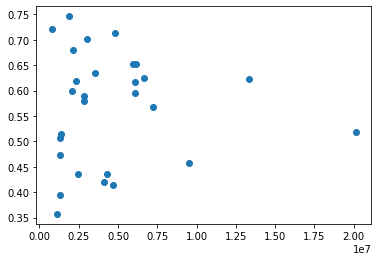

In [15]:
#NHL data
new_df = pd.merge(nhl_df,cities,how='inner',on='Metropolitan area')
    
population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

corrcoef = stats.pearsonr(population_by_region, win_loss_by_region)[0]

plt.figure()
plt.scatter(population_by_region,win_loss_by_region)
plt.show()

In [16]:
lat_lon = pd.Series(mapping.lat_lon)
lat_lon.name = 'lat_lon'
new_df = pd.merge(new_df,lat_lon,how='inner',left_index=True,right_index=True)

In [17]:
new_df
new_df['lat'] = new_df['lat_lon'].map(lambda x: x[0])
new_df['lon'] = new_df['lat_lon'].map(lambda x: x[1])

In [33]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.offline import plot
import plotly.io as pio

df = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(df, locations="iso_alpha",
                     color="continent", # which column to use to set the color of markers
                     hover_name="country", # column added to hover information
                     size="pop", # size of markers
                     projection="natural earth")

plot(fig)

fig = go.Figure(data=go.Scattergeo(
        lon = new_df['lon'].astype('float64'),
        lat = new_df['lat'].astype('float64'),
        mode = 'markers',
        marker_color = new_df['Population'],
        ))

fig.update_layout(
        title = 'Most trafficked US airports<br>(Hover for airport names)',
        geo_scope='usa',
    )
plot(fig)

'temp-plot.html'

In [55]:
#NBA data
new_df = pd.merge(nba_df,cities,how='inner',on='Metropolitan area')

population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

stats.pearsonr(population_by_region, win_loss_by_region)[0]

-0.17657160252844617

In [56]:
#MLB data
new_df = pd.merge(mlb_df,cities,how='inner',on='Metropolitan area')

population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

stats.pearsonr(population_by_region, win_loss_by_region)[0]

0.15027698302669307

In [57]:
#NFL data
new_df = pd.merge(nfl_df,cities,how='inner',on='Metropolitan area')

population_by_region = new_df['Population']
win_loss_by_region = new_df['W/L']

stats.pearsonr(population_by_region, win_loss_by_region)[0]    

0.004922112149349428

In [ ]:
##Scatterplot Geomap. Punktgröße abhängig von Bevölkerung Farbe abhängig von W/L Ratio